In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [51]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Drop unnecessary columns (e.g., PassengerId, Name, Ticket, Cabin)
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Handle missing values
# - Fill missing Age with median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# - Fill missing Embarked with the most frequent value
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# - Fill missing Fare in test data
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Convert categorical features to numerical
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Embarked'] = test_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.361582    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.019697    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   28.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean    32.204208    1.536476  
std     49.693429    0.791503  
min      0.000000    0.000000  
25%      7.910400    1.000000  
50%     14.454200    2.000000  
75%     31.000000    2.000000  
max    512.329

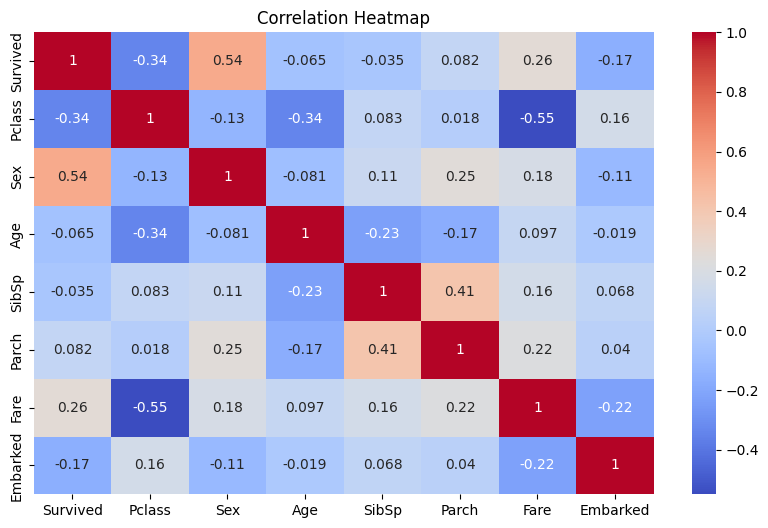

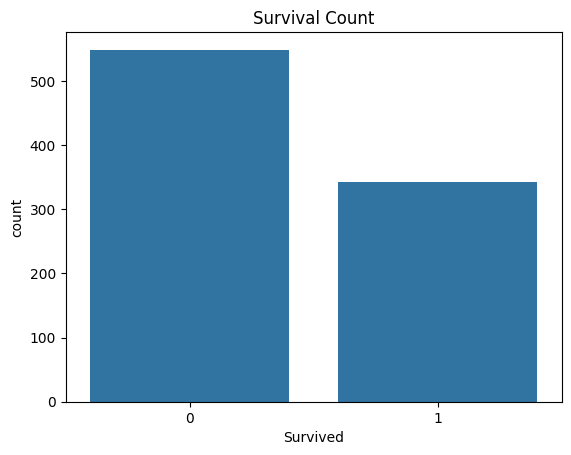

In [52]:
print(train_df.describe())

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sns.countplot(data=train_df, x='Survived')
plt.title('Survival Count')
plt.show()


In [53]:
# Define features and target variable
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Split into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_df = scaler.transform(test_df)


In [54]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, y, y_hat):
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_hat = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_hat - y))
            db = (1 / n_samples) * np.sum(y_hat - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            #if _ % 100 == 0:  # Debugging loss every 100 iterations
            #    print(f"Loss after {_} iterations: {self.loss(y, y_hat)}")

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_hat = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_hat]


def train_and_evaluate(X_train, y_train, X_val, y_val, learning_rate, iterations):
    model = LogisticRegressionScratch(
        learning_rate=learning_rate, iterations=iterations
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    return accuracy, precision, recall, f1


In [ ]:
class NewtonLogisticRegression:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_hat = self.sigmoid(linear_model)
            grad_w = np.dot(X.T, (y_hat - y)) / n_samples
            grad_b = np.sum(y_hat - y) / n_samples

            # Матрица Гессе
            S = np.diag(y_hat * (1 - y_hat))
            H = np.dot(X.T, np.dot(S, X)) / n_samples

            # Обновление весов и смещения
            H_inv = np.linalg.inv(H + 1e-5 * np.eye(H.shape[0]))
            self.weights -= np.dot(H_inv, grad_w)
            self.bias -= grad_b

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_hat = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_hat]


In [56]:
# Сравнение методов оптимизации
def compare_optimizers(X_train, y_train, X_val, y_val, learning_rate, iterations):
    # Градиентный спуск
    gradient_model = LogisticRegressionScratch(learning_rate=learning_rate, iterations=iterations)
    gradient_model.fit(X_train, y_train)
    gradient_predictions = gradient_model.predict(X_val)

    # Метод Ньютона
    newton_model = NewtonLogisticRegression(iterations=iterations)
    newton_model.fit(X_train, y_train)
    newton_predictions = newton_model.predict(X_val)

    # Метрики
    metrics = {
        "Gradient": {
            "accuracy": accuracy_score(y_val, gradient_predictions),
            "f1_score": f1_score(y_val, gradient_predictions),
        },
        "Newton": {
            "accuracy": accuracy_score(y_val, newton_predictions),
            "f1_score": f1_score(y_val, newton_predictions),
        },
    }

    return metrics

learning_rates = [0.001, 0.01, 0.1, 0.2]
iterations_list = [100, 500, 1000, 2000]

results = []

for lr in learning_rates:
    for iters in iterations_list:
        acc, prec, rec, f1 = train_and_evaluate(X_train, y_train, X_val, y_val, lr, iters)
        results.append({'learning_rate': lr, 'iterations': iters, 
                        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1})


C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    learning_rate  iterations  accuracy  precision    recall  f1_score
0           0.001         100  0.614350   0.000000  0.000000  0.000000
1           0.001         500  0.614350   0.000000  0.000000  0.000000
2           0.001        1000  0.618834   1.000000  0.011628  0.022989
3           0.001        2000  0.672646   1.000000  0.151163  0.262626
4           0.010         100  0.618834   1.000000  0.011628  0.022989
5           0.010         500  0.735426   0.965517  0.325581  0.486957
6           0.010        1000  0.784753   0.851852  0.534884  0.657143
7           0.010        2000  0.775785   0.725000  0.674419  0.698795
8           0.100         100  0.784753   0.851852  0.534884  0.657143
9           0.100         500  0.771300   0.716049  0.674419  0.694611
10          0.100        1000  0.766816   0.707317  0.674419  0.690476
11          0.100        2000  0.784753   0.726190  0.709302  0.717647
12          0.200         100  0.775785   0.725000  0.674419  0.698795
13    

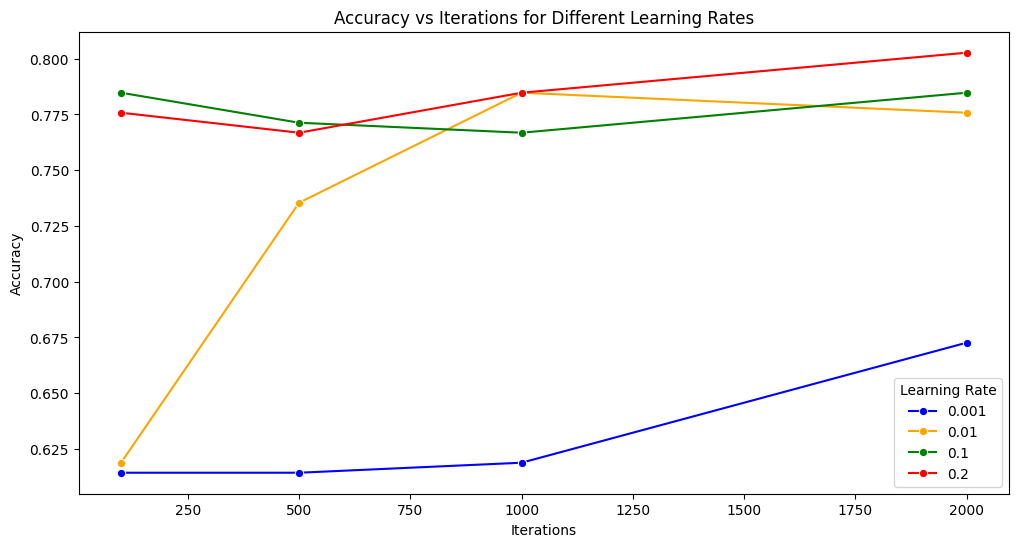

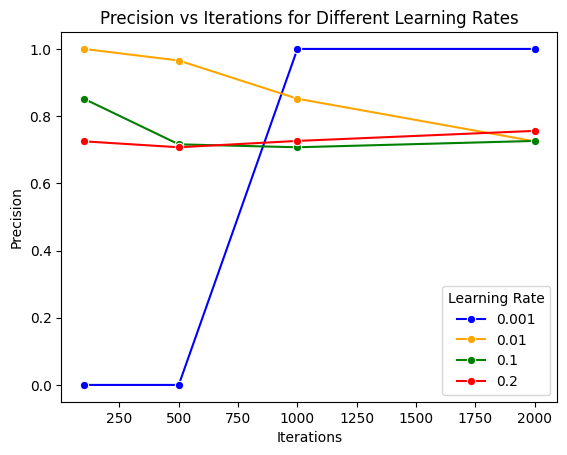

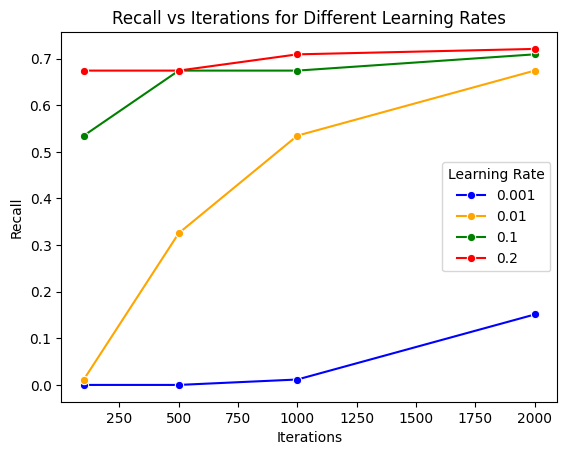

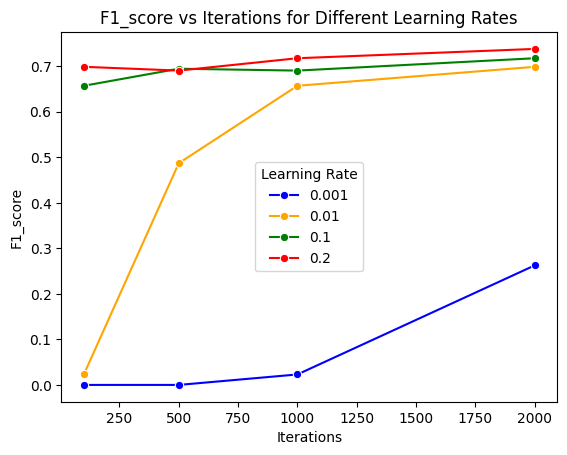

In [57]:
results_df = pd.DataFrame(results)
print(results_df)
plt.figure(figsize=(12, 6))
palette = {
    0.001: "blue",
    0.01: "orange",
    0.1: "green",
    0.2: "red",
}
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    sns.lineplot(data=results_df, x='iterations', y=metric, hue='learning_rate', marker='o',palette=palette)
    plt.title(f"{metric.capitalize()} vs Iterations for Different Learning Rates")
    plt.xlabel('Iterations')
    plt.ylabel(metric.capitalize())
    plt.legend(title="Learning Rate")
    plt.show()

In [58]:
model = LogisticRegressionScratch(0.01,2000)
scaler.transform(X)
model.fit(X,y)
predictions = model.predict(test_df)
submission = pd.DataFrame({'PassengerId': pd.read_csv('test.csv')['PassengerId'], 'Survived': predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


In [61]:
metrics = compare_optimizers(X_train, y_train, X_val, y_val, learning_rate=0.01, iterations=2000)
print("Gradient Descent:")

print(f"Accuracy: {metrics['Gradient']['accuracy']}")
print(f"f1 score: {metrics['Gradient']['f1_score']}")
print("Newton's Method:")
print(f"Accuracy: {metrics['Newton']['accuracy']}")
print(f"f1 score: {metrics['Newton']['f1_score']}")

Gradient Descent:
Accuracy: 0.7757847533632287
f1 score: 0.6987951807228916
Newton's Method:
Accuracy: 0.8026905829596412
f1 score: 0.7441860465116279
